In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
import os
import glob as glob
import numpy as np
import datetime
from keras.models import Model , Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tensorflow.keras import layers

%matplotlib inline

from tensorflow.keras.utils import img_to_array, load_img
import tensorflow as tf


In [2]:
# default settings
img_width, img_height = 128, 128

train_dir = '/Users/ayberk/Retina-Damage-Detection-OCT-Images/Dataset/train'
validate_dir = '/Users/ayberk/Retina-Damage-Detection-OCT-Images/Dataset/test'
nb_epochs = 20
batch_size = 16
nb_classes = len(glob.glob(train_dir + '/*'))

nb_train_samples = sum(len(files) for _, _, files in os.walk(train_dir))
print(nb_train_samples)

nb_validate_samples = sum(len(files) for _, _, files in os.walk(validate_dir))
print(nb_validate_samples)

11003
969


In [3]:
# data pre-processing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True
)

In [4]:
# data pre-processing for validation
validate_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True
)

In [5]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size
)

Found 10998 images belonging to 4 classes.


In [6]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size
)

Found 968 images belonging to 4 classes.


In [7]:
# Calculate class weight
total = len(validate_dir)
count_cnv = 2874
count_dme = 2760
count_drusen = 2766
count_normal = 2598
cnv_weight = (1/count_cnv) * (total/4)
dme_weight = (1/count_dme) * (total/4)
drusen_weight = (1/count_drusen) * (total/4)
norm_weight = (1/count_normal) * (total/4)
class_weight = {0: cnv_weight, 1: dme_weight, 2: drusen_weight, 3: norm_weight}
print("Class Weights: 0CVN - 1DME - 2DRUSEN - 3NORMAL" + str(class_weight))

Class Weights: 0CVN - 1DME - 2DRUSEN - 3NORMAL{0: 0.005306193458594294, 1: 0.00552536231884058, 2: 0.005513376717281272, 3: 0.005869899923017705}


In [8]:
#Adding Batch Normalization and Dropout Cnn-Model
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(renorm=True),
    layers.Dropout(0.3),
    layers.Dense(units=4, activation='softmax'),
])

In [9]:
model.compile(
    optimizer=RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 3)      21        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       448       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                        

In [11]:
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit(
    train_generator,
    epochs=nb_epochs,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validate_generator,
    validation_steps=nb_validate_samples // batch_size,
    class_weight=class_weight,
)

Epoch 1/20


2023-06-13 22:12:13.146856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-13 22:12:13.154080: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


687/687 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.3833

2023-06-13 22:25:05.625169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


687/687 [==============================] - 792s 1s/step - loss: 0.0199 - accuracy: 0.3833 - val_loss: 0.7885 - val_accuracy: 0.6979
Epoch 2/20
687/687 [==============================] - 764s 1s/step - loss: 0.0048 - accuracy: 0.6656 - val_loss: 0.4974 - val_accuracy: 0.8094
Epoch 3/20
687/687 [==============================] - 786s 1s/step - loss: 0.0035 - accuracy: 0.7663 - val_loss: 0.2938 - val_accuracy: 0.9104
Epoch 4/20
687/687 [==============================] - 780s 1s/step - loss: 0.0031 - accuracy: 0.8019 - val_loss: 0.2925 - val_accuracy: 0.8896
Epoch 5/20
687/687 [==============================] - 776s 1s/step - loss: 0.0026 - accuracy: 0.8355 - val_loss: 0.2175 - val_accuracy: 0.9344
Epoch 6/20
687/687 [==============================] - 777s 1s/step - loss: 0.0024 - accuracy: 0.8498 - val_loss: 0.1603 - val_accuracy: 0.9448
Epoch 7/20
687/687 [==============================] - 768s 1s/step - loss: 0.0021 - accuracy: 0.8625 - val_loss: 0.2183 - val_accuracy: 0.9344
Epoch 8/20

In [12]:
model.save("octcustommodel.h5")
model.save_weights("octcustomweights.h5")
with open("octcustom.json", "w") as f:
    json.dump(transfer_learning_history.history, f)

In [13]:
print('Training time: %s' % (now() - t))

Training time: 4:15:49.245107


In [14]:
score = model.evaluate(
    validate_generator, steps=nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

2023-06-14 02:28:02.394305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 22s 355ms/step - loss: 0.0713 - accuracy: 0.9814
Test Score: 0.07131718099117279
Test Accuracy: 0.9814049601554871


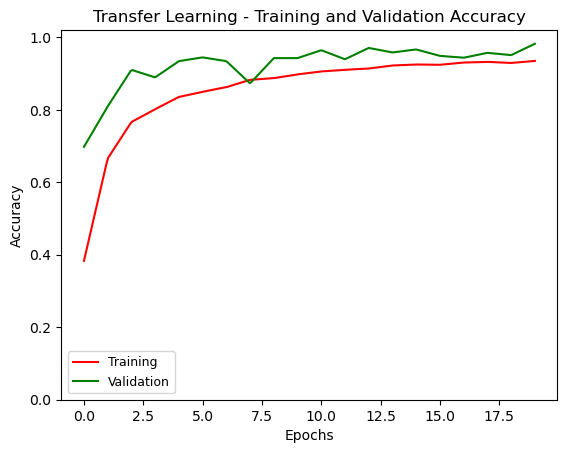

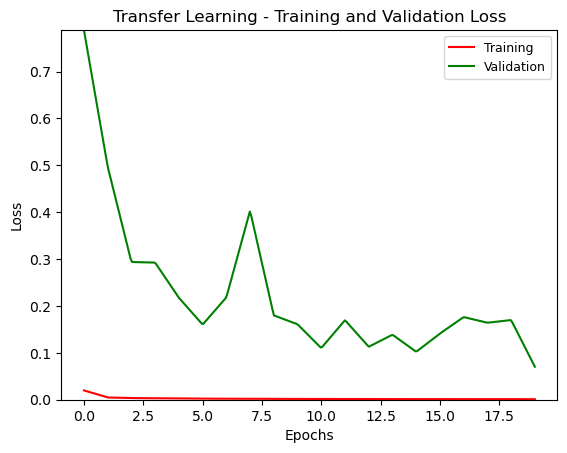

In [15]:
xfer_acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = interp1d(x, y, kind='linear')(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label='Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = interp1d(x1, y1, kind='linear')(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label='Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc='lower left', fontsize=9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1.02)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = interp1d(x, y, kind='linear')(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label='Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = interp1d(x1, y1, kind='linear')(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label='Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc='upper right', fontsize=9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, max(y1))
plt.show()

2023-06-14 02:28:24.444076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


61/61 [==============================] - 22s 353ms/step
Found 968 files belonging to 4 classes.


2023-06-14 02:28:46.279387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [968]
	 [[{{node Placeholder/_4}}]]
2023-06-14 02:28:46.279624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [968]
	 [[{{node Placeholder/_4}}]]


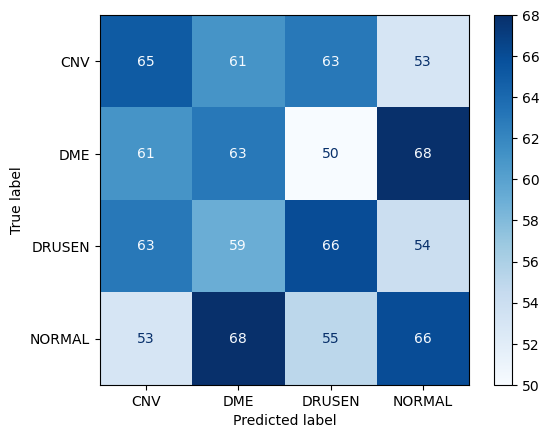

In [16]:
predictions = model.predict(validate_generator)
# Convert prediction probabilities into integers
predictions = np.argmax(predictions, axis=1)

class_labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

class_names = class_labels

test = tf.keras.preprocessing.image_dataset_from_directory(
    validate_dir,
    labels='inferred',
    image_size=(224, 224),
    batch_size=16,
    color_mode='rgb',
)
test_labels = [labels for _, labels in test.unbatch()]

cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [17]:
print(validate_generator.total_batches_seen)

1345
